# CS 4262: Predicting a Playlist for a Song

<br>by Keshvi Mahalingam, Zinnie Zhang</br>


In [3]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time 
%matplotlib inline

# Run "pip install spotipy" on your local computer
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [4]:
# Access Spotify Credentials
client_id = '6d02153904514353ac63fd23acba8d86'
client_secret = '06a9d4ba2e104061b268c6ba7a41c60f'
client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [20]:
# Get track ID for a specific user and playlist ID. (Playlist ID found in URL when clicking "share")
# n = number of songs 
def getTrackIDs(user, playlist_id, n = 50):
    ids = []
    playlist = sp.user_playlist(user, playlist_id)
    
    count = 0
    for item in playlist['tracks']['items']:
        track = item['track']
        ids.append(track['id'])
        count += 1
        if count == n: break
        
    return ids

# Get track features
def getTrackFeatures(id):
    meta = sp.track(id)
    features = sp.audio_features(id)

    # meta
    length = meta['duration_ms']
    popularity = meta['popularity']

    # features
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    instrumentalness = features[0]['instrumentalness']
    key = features[0]['key']
    liveness = features[0]['liveness']
    loudness = features[0]['loudness']
    mode = features[0]['mode']
    speechiness = features[0]['speechiness']
    tempo = features[0]['tempo']
    time_signature = features[0]['time_signature']
    valence = features[0]['valence']

    track = [length, popularity, acousticness, danceability, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, time_signature, valence]
    return track

# Loop track and create dataset
def trackCSV(ids, name):
    tracks = []
    for i in range(len(ids)):
        track = getTrackFeatures(ids[i])
        tracks.append(track)
    
    # create CSV
    df = pd.DataFrame(tracks, columns = ['length', 'popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence'])
    df.to_csv(name + ".csv", sep = ',')
    print(name + 'CSV created\n')
    
    return df

In [21]:
happyIds = getTrackIDs('xinyizhang.x-ca', '37i9dQZF1DXdPec7aLTmlC')
happy_data = trackCSV(happyIds, 'happy')

sadIds = getTrackIDs('xinyizhang.x-ca', '6nxPNnmSE0d5WlplUsa5L3')
sad_data = trackCSV(sadIds, 'sad')


happyCSV created

sadCSV created



# Exploratory Data Analysis
General Statistics, Correlation Map, Visual Plot of Each Feature, PCA

Happy Songs General Statistics



<AxesSubplot:>

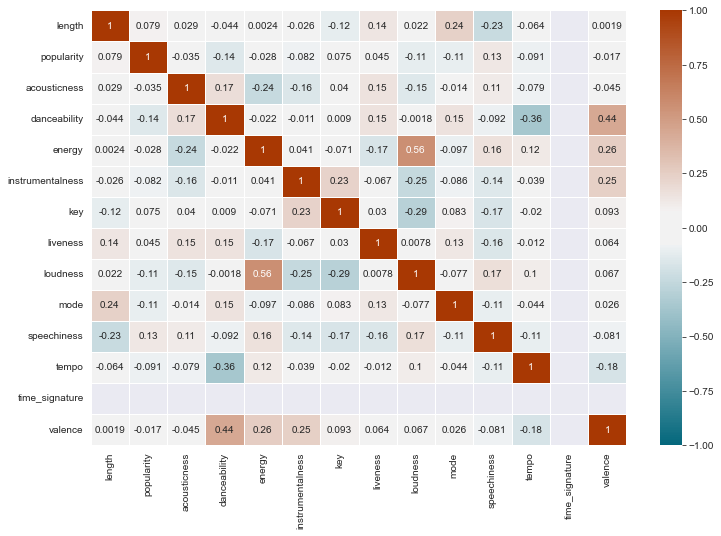

In [22]:
# [length, popularity, acousticness, danceability, energy, instrumentalness, 
# key, liveness, loudness, mode, speechiness, tempo, time_signature, valence]

# General Statistics
print('Happy Songs General Statistics\n')
happy_data.describe()

# Correlation Map
sns.set_style('darkgrid')
plt.figure(figsize = (12,8))
cmap = sns.diverging_palette(220, 20, l = 40, s = 99, sep = 20, center = 'light', as_cmap = True) 
sns.heatmap(happy_data.corr(), vmin = -1, vmax = 1, annot = True, cmap = cmap, lw = .5, linecolor = 'white')


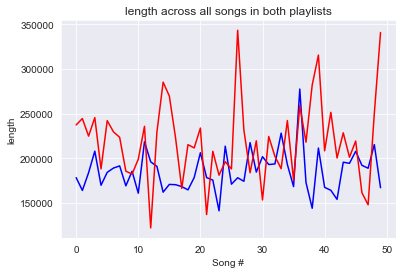

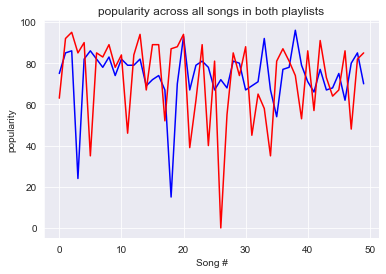

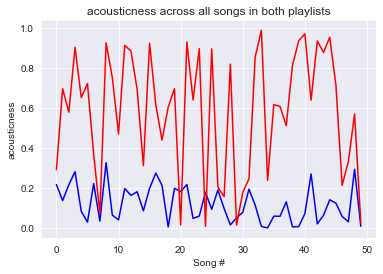

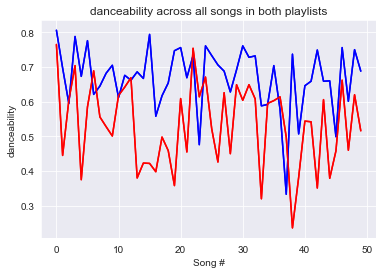

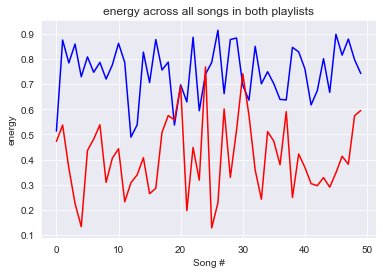

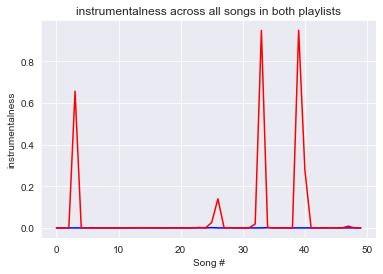

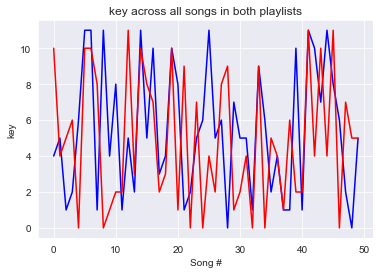

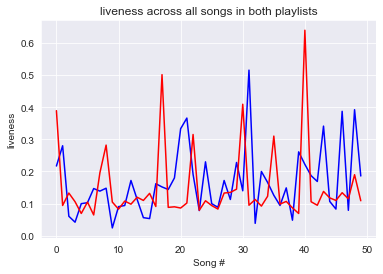

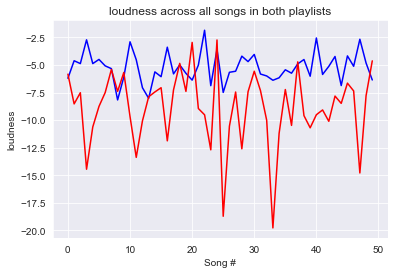

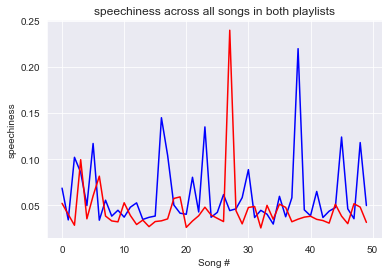

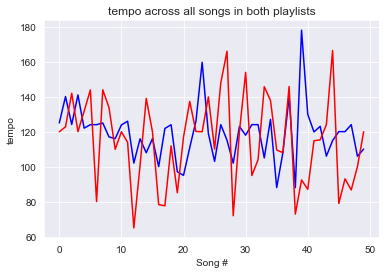

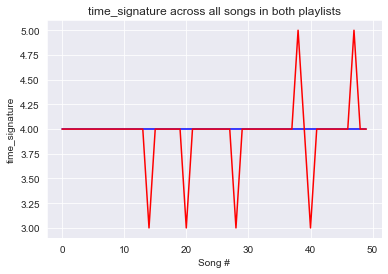

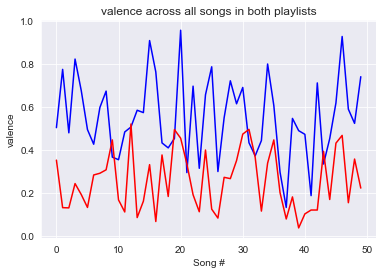

In [23]:
# Plot all features to visually see the greatest seperation
features = ['length', 'popularity', 'acousticness', 'danceability', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature', 'valence']

for feature in features:
    plt.figure(feature)
    plt.plot(happy_data[feature], color='blue')
    plt.plot(sad_data[feature], color='red')
    plt.xlabel("Song #")
    plt.ylabel(feature)
    plt.title(feature + " across all songs in both playlists")



In [29]:
# Scale data
from sklearn.preprocessing import StandardScaler

# Happy data
scaler = StandardScaler()
scaler.fit(happy_data)
scaled_happy_data = scaler.transform(happy_data)

# Sad data
scaler = StandardScaler()
scaler.fit(sad_data)
scaled_sad_data = scaler.transform(sad_data)

# Combine data
df_scaled_happy = pd.DataFrame(scaled_happy_data, columns = ['length', 'popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence'])
df_scaled_sad = pd.DataFrame(scaled_sad_data, columns = ['length', 'popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence'])
combined = pd.concat([df_scaled_happy, df_scaled_sad])

Text(0, 0.5, 'Ratio of Variance Explained')

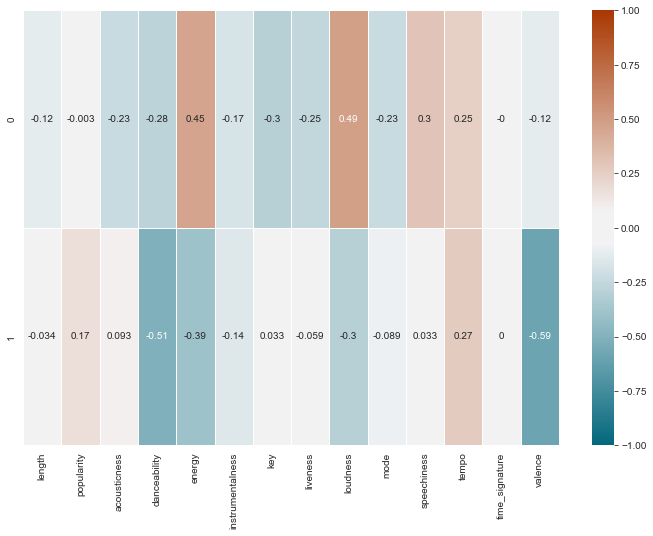

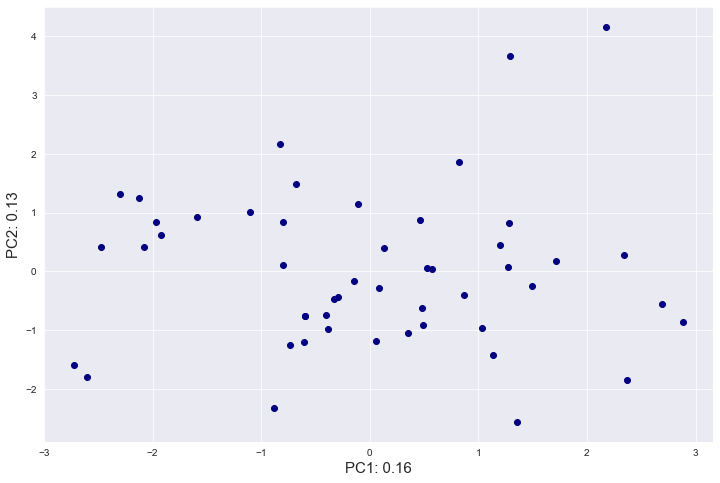

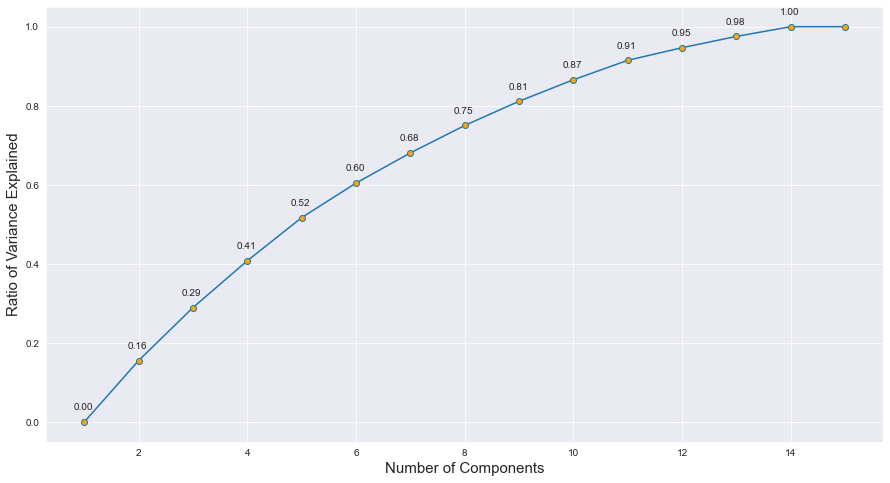

In [32]:
# PCA with 2 components
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit(scaled_happy_data)
data_pca = pca.transform(scaled_happy_data)

pca_corr = pd.DataFrame(pca.components_, columns = happy_data.columns)

plt.figure(figsize = (12,8))
sns.heatmap(pca_corr, cmap = cmap, vmin = -1, vmax = 1, annot = True, lw = .5, linecolor = 'white')

plt.figure(figsize = (12, 8))
plt.scatter(data_pca[:,0], data_pca[:,1], c = 'navy')
plt.xlabel('PC1: {:.2f}'.format(pca.explained_variance_ratio_[0]), size = 15)
plt.ylabel('PC2: {:.2f}'.format(pca.explained_variance_ratio_[1]), size = 15)

# PCA with 0-14 components
exp_var_ratio = []
for n in range(0,15):
    pca = PCA(n_components = n)
    pca.fit(scaled_happy_data)
    pca.transform(scaled_happy_data)
    exp_var_ratio.append(sum(pca.explained_variance_ratio_))

fig = plt.figure(figsize = (15, 8))
ax = fig.add_subplot(111)
plt.plot(range(1,16), exp_var_ratio, marker = 'o', markerfacecolor = 'orange', markersize = 6)

for i,j in zip(range(1,15),exp_var_ratio):
    ax.annotate('{:.2f}'.format(j),xy=(i-.2,j+.03))
plt.xlabel('Number of Components', size = 15)
plt.ylabel('Ratio of Variance Explained', size = 15)

# Model Selection (Potential)
KNN

In [50]:
# Label y values 
# Happy = 0
# Sad = 1

from sklearn.model_selection import train_test_split
X = combined

y_0 = []
y_1 = []
for _ in range(50):
    y_0.append(0)
    y_1.append(1)

y_0.extend(y_1)
print(y_0)

# Split into train, test
X_train, X_test, y_train, y_test = train_test_split(X, y_0, test_size=0.3, random_state=30, shuffle=True)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [51]:
import math
from sklearn.neighbors import KNeighborsClassifier

# Find k value 
k = math.floor(math.sqrt(len(y_train))/2)
print(k)

# Train model
knn = KNeighborsClassifier(n_neighbors=k,p=2,metric='euclidean')
knn.fit(X_train, y_train)


# Make predictions
prediction = knn.predict(X_test)
correct = 0
m = len(y_test)
for i in range(m):
    if prediction[i] == y_test[i]: correct +=1
        
performance = correct/m

print('Performance: ', performance)

4
Performance:  0.4666666666666667
